In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
        
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce')
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    
    tweet_dfs.append(tweet_df)

In [4]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [5]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [6]:
log_s_j_x = []
for i in range(num_root_tweets):
    s_j_x = sorted(generate_reaction_times(tweet_dfs[i]).values())
    log_s_j_x.append([np.log(i.seconds) for i in s_j_x])
fake_logs = [[1 for i in range(num_root_tweets)] for j in range(5)]

In [ ]:
# pymc3 model 
with pm.Model() as twitter_model:
    # global model parameters
    # Time-related hyperparameters
    alpha = pm.Normal('alpha', mu=0, sd=100) #eq 5
    sigma_squared_delta = pm.InverseGamma('sigma_squared_delta', alpha=2, beta=2) # eq 6
    log_a_tau = pm.Normal('log_a_tau', mu=0, sd=10) # eq 7
    b_tau = pm.Gamma('b_tau', alpha=1, beta=.002) # eq 8
    
    # binom model for graph structure
    beta_0 = pm.Normal('beta_0', mu=0, sd=100) # eq 12
    beta_F = pm.Normal('beta_F', mu=0, sd=100) # eq 13
    beta_d = pm.Normal('beta_d', mu=0, sd=100) # eq 14
    sigma_squared_b = pm.InverseGamma('sigma_squared_b', alpha=0.5, beta=0.5, testval=10000) # eq 15
    
    # log-normal model for reaction times, nonrecursive...
    a_tau = pm.Deterministic('a_tau', pm.math.exp(log_a_tau))
    for i in range(2): # num_root_tweets
        t_x = pm.InverseGamma('tau_x_squared_' + str(i), alpha=a_tau, beta=b_tau) # eq 4
        a_x = pm.Normal('alpha_x_' + str(i), mu=alpha, tau=1/sigma_squared_delta) # eq 3
        log_S_j_x = pm.Normal('log_s_j_x_' + str(i), mu=a_x, tau=t_x**0.5, observed=log_s_j_x[i]) # eq 2
        
        # binom model for user
        for x, row in tweet_dfs[i].iterrows():
            if x > 5: 
                break # try for performance reasons
            f_j_x = int(row['FollowerCount']) 
            d_j_x = row['DistanceFromRoot']
            mu_j_x = pm.Deterministic('mu_j_x' + str(x) + "_" + str(i), 
                    beta_0 + beta_F*pm.math.log(f_j_x + 1) + beta_d*pm.math.log(d_j_x + 1)) # eq 11
            logit_b_j_x = pm.Normal('logit_b_j_x' + str(x) + "_" + str(i), mu=mu_j_x, sd=sigma_squared_b) # eq 10
            
            b_j_x = pm.Deterministic('b_j_x' + str(x) + "_" + str(i), pm.math.invlogit(logit_b_j_x))
            
            M_j_x = pm.Binomial('M_j_x' + str(x) + "_" + str(i), n = f_j_x, p = b_j_x) # eq 9


In [ ]:
# run model
with twitter_model:
    trace = pm.sample(1000,tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [M_j_x10_1]
>>Metropolis: [M_j_x9_1]
>>Metropolis: [M_j_x8_1]
>>Metropolis: [M_j_x7_1]
>>Metropolis: [M_j_x6_1]
>>Metropolis: [M_j_x5_1]
>>Metropolis: [M_j_x4_1]
>>Metropolis: [M_j_x3_1]
>>Metropolis: [M_j_x2_1]
>>Metropolis: [M_j_x1_1]
>>Metropolis: [M_j_x0_1]
>>Metropolis: [M_j_x10_0]
>>Metropolis: [M_j_x9_0]
>>Metropolis: [M_j_x8_0]
>>Metropolis: [M_j_x7_0]
>>Metropolis: [M_j_x6_0]
>>Metropolis: [M_j_x5_0]
>>Metropolis: [M_j_x4_0]
>>Metropolis: [M_j_x3_0]
>>Metropolis: [M_j_x2_0]
>>Metropolis: [M_j_x1_0]
>>Metropolis: [M_j_x0_0]
>NUTS: [logit_b_j_x10_1, logit_b_j_x9_1, logit_b_j_x8_1, logit_b_j_x7_1, logit_b_j_x6_1, logit_b_j_x5_1, logit_b_j_x4_1, logit_b_j_x3_1, logit_b_j_x2_1, logit_b_j_x1_1, logit_b_j_x0_1, alpha_x_1, tau_x_squared_1_log__, logit_b_j_x10_0, logit_b_j_x9_0, logit_b_j_x8_0, logit_b_j_x7_0, logit_b_j_x6_0, logit_b_j_x5_0, logit_b_j_x4_0, logit_b_j_x3_0, logit_b_j_x2_0, logit_b_j_x1_0

alpha: 7.63741452404(0.307661597266)
sigma_squared_delta: 0.879298339925(0.622426993366)
a_tau: 5284.71485981(5216.2298663)
b_tau: 235.774049617(232.880233536)


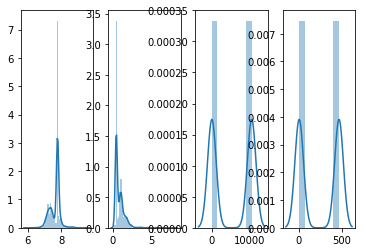

In [13]:
# graph all of the 
with twitter_model:
    imp_dists = ['alpha', 'sigma_squared_delta', 'a_tau', 'b_tau']
#                 'beta_0', 'beta_F', 'beta_d']
    fig, axs = plt.subplots(ncols=len(imp_dists))
    for i in range(len(imp_dists)):
        var = imp_dists[i]
        sns.distplot(trace[var], ax=axs[i]);
        print(var + ": " + str(np.mean(trace[var])) + "(" + str(np.std(trace[var])) + ")")
